In this notebook, we are going to use autoencoder architecture in Pytorch to reduce feature dimensions and visualiations.

First, to install PyTorch, you may use the following pip command,

```
$ pip install torch torchvision
```

The `torchvision` package contains the image data sets that are ready for use in PyTorch.

More details on its installation through [this guide](https://pytorch.org/get-started/locally/) from [pytorch.org](pytorch.org).

## Setup

importing relevant dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

Set seed and other configurations for reproducibility.

In [2]:
seed = 21
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Set the batch size, the number of training epochs, and the learning rate.

In [3]:
batch_size = 512
epochs = 50
learning_rate = 1e-3

## Dataset

load the MNIST dataset as a convienient exampe using the `torchvision` package. 

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

check one example data

In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data[0][0].max()

tensor(1.)

## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: 
(1) an encoder learns the data representation in lower-dimension space, 
(2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

In the following we define our autoencoder class with fully connected layers and activation functions for both its encoder and decoder components.

In [7]:
from torch import Tensor

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=1000
        )
        self.encoder_output_layer = nn.Linear(
            in_features=1000, out_features=128
        )
        self.encoder_output_layer2 = nn.Linear(
            in_features=128, out_features=32
        )
        self.encoder_output_layer3 = nn.Linear(
            in_features=32, out_features=2
        )
        
        
            
        self.decoder_hidden_layer = nn.Linear(
            in_features=2, out_features=32
        )
        self.decoder_hidden_layer2 = nn.Linear(
            in_features=32, out_features=128
        )
        self.decoder_hidden_layer3 = nn.Linear(
            in_features=128, out_features=1000
        )
        
        
        self.decoder_output_layer = nn.Linear(
            in_features=1000, out_features=kwargs["input_shape"]
        )


    
    def encode(self, features: Tensor) -> Tensor:
        code = self.encoder_hidden_layer(features)
        code = torch.relu(code)
        code = self.encoder_output_layer(code)
        code = torch.relu(code)
        code = self.encoder_output_layer2(code)
        code = torch.relu(code)
        code = self.encoder_output_layer3(code)
        
        return code

    def decode(self, encoded: Tensor) -> Tensor:
        
        encode = self.decoder_hidden_layer(encoded)
        encode = torch.relu(encode)
        encode = self.decoder_hidden_layer2(encode)
        encode = torch.relu(encode)
        encode = self.decoder_hidden_layer3(encode)
        encode = torch.relu(encode)
        encode = self.decoder_output_layer(encode)
        reconstructed = torch.sigmoid(encode)
        
        return reconstructed   
    
    def forward(self, features: Tensor) -> Tensor:
        encoded = self.encode(features)
        return self.decode(encoded)

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [8]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

We train our autoencoder for our specified number of epochs.

In [9]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/50, recon loss = 0.07389576
epoch : 2/50, recon loss = 0.05296296
epoch : 3/50, recon loss = 0.04810659
epoch : 4/50, recon loss = 0.04541392
epoch : 5/50, recon loss = 0.04336656
epoch : 6/50, recon loss = 0.04195889
epoch : 7/50, recon loss = 0.04092639
epoch : 8/50, recon loss = 0.04033839
epoch : 9/50, recon loss = 0.03984492
epoch : 10/50, recon loss = 0.03948938
epoch : 11/50, recon loss = 0.03939159
epoch : 12/50, recon loss = 0.03877884
epoch : 13/50, recon loss = 0.03859487
epoch : 14/50, recon loss = 0.03825530
epoch : 15/50, recon loss = 0.03797148
epoch : 16/50, recon loss = 0.03789599
epoch : 17/50, recon loss = 0.03754379
epoch : 18/50, recon loss = 0.03740290
epoch : 19/50, recon loss = 0.03735819
epoch : 20/50, recon loss = 0.03729593
epoch : 21/50, recon loss = 0.03699356
epoch : 22/50, recon loss = 0.03768872
epoch : 23/50, recon loss = 0.03694447
epoch : 24/50, recon loss = 0.03680794
epoch : 25/50, recon loss = 0.03654349
epoch : 26/50, recon loss = 0.0363

Let's extract some test examples to reconstruct using our trained autoencoder.

In [10]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

# loop the test data once to get the first batch of 10 datapoints for reconstruction quality check
with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        reconstruction_hidden = model.encode(test_examples)
        break

## Visualize Reconstruction Quality

Let's try to reconstruct some test images using our trained autoencoder.

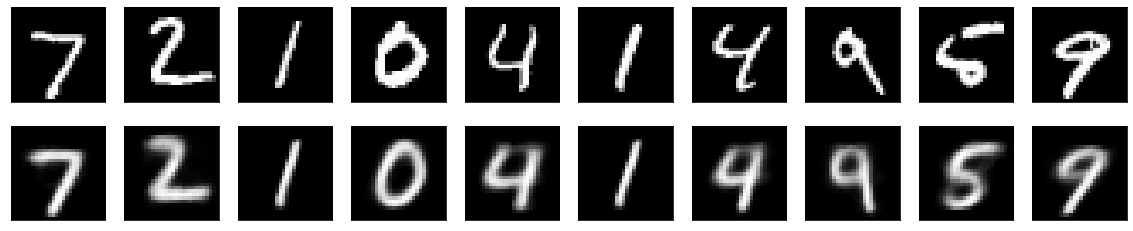

In [11]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Analysis so far 
as we can see the reconstruciton is good, but not super great; this is mainly because we use only 2 nodes for the 
middle hidden layer. Using only 2 nodes is easy for us to see the reduced dimensions, but probably not good enough
to capture all the sailent features. For pure feature reduction purpose, we can choose a bigger number of nodes
for the middel hidden layer.


## Visualize the middel hidden layer with 2 nodes for lower dimension reduction


In [12]:
# reduce dimension example

results =[]
with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction_hidden = model.encode(test_examples)
        results.append(reconstruction_hidden.numpy())
        

In [13]:
import numpy as np
all_hidden = np.concatenate(results)
all_hidden

array([[-0.43485078,  0.31671965],
       [ 1.5935664 ,  4.4088674 ],
       [ 9.075943  ,  4.4781566 ],
       ...,
       [-0.90027434,  0.3994102 ],
       [-2.9567816 ,  2.2586362 ],
       [-4.884531  ,  1.9589175 ]], dtype=float32)

In [14]:
labels = test_dataset.targets.numpy()

<AxesSubplot:xlabel='x', ylabel='y'>

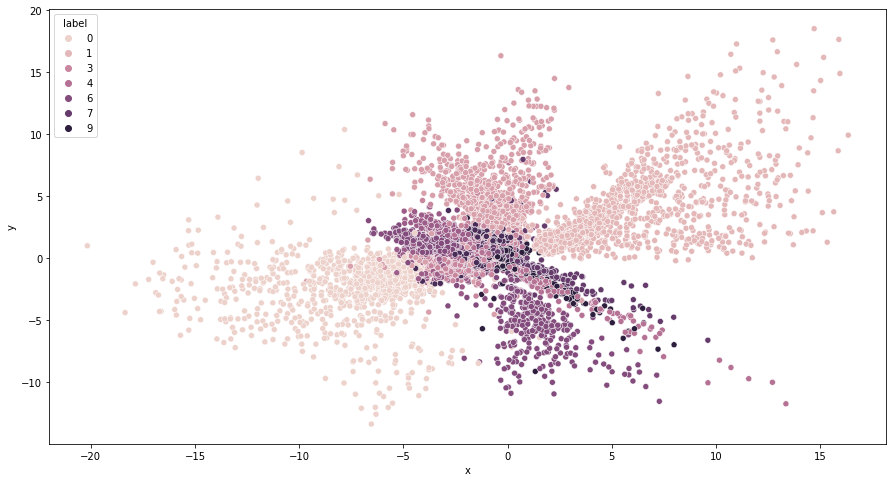

In [15]:
import pandas as pd
rdf = pd.DataFrame(all_hidden)
rdf['lable'] = labels
rdf.columns = ['x','y','label']

from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))  
sns.scatterplot(data=rdf,x='x',y='y',hue='label')